In [1]:
from pathlib import Path

import cv2 as cv

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

from scipy import ndimage as ndi
from skimage import filters, measure

In [2]:
plt.set_cmap(cm.gray)

<Figure size 432x288 with 0 Axes>

### Define configurations

In [3]:
CASCADE_DIR_PATH = Path('../cascades')
CHOSEN_CASCADE = CASCADE_DIR_PATH / 'haarcascade_russian_plate_number.xml'
PLATE_CASCADE = cv.CascadeClassifier(str(CHOSEN_CASCADE))

DATA_DIR = Path('../data/real')
BBOX_COLOR = (255, 0, 0)
BBOX_THICKNESS = 2

BASE_MIN_NEIGHBOURS = 5
SCALE = 1.2

### Define util functions

In [4]:
def convert_to_greyscale(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [325]:
def cut_detection(image, detection, greyscale=False):
    """Cut detection from image: detection format: (x, y, w, h)"""
    (x, y, w, h) = detection
    cut = image[y:y + h, x:x + w]
    
    if greyscale:
        return convert_to_greyscale(cut)
    return cut

In [324]:
def try_detect(gray):
    nb_neighbours = BASE_MIN_NEIGHBOURS
    detections = PLATE_CASCADE.detectMultiScale(gray, minNeighbors=nb_neighbours)

    while len(detections) == 0 and nb_neighbours >= 0:
        nb_neighbours -= 1
        detections = PLATE_CASCADE.detectMultiScale(gray, minNeighbors=nb_neighbours)
    return detections

In [7]:
def detect_plates(image, greyscale=False):
    gray = convert_to_greyscale(image)
    detections = try_detect(gray)
    
    cut_plates = []
    for (x, y, w, h) in detections:
        cv.rectangle(image, (x, y), (x + w, y + h),
                     color=BBOX_COLOR,
                     thickness=BBOX_THICKNESS)

        plate = cut_detection(image, (x, y, w, h), greyscale)
        cut_plates.append(plate)

    return cut_plates

In [8]:
def rotate_image(image, degree):
    rows, cols = image.shape[:2]
    matrix = cv.getRotationMatrix2D((cols / 2, rows / 2), degree, 1)
    return cv.warpAffine(image, matrix, (cols, rows))

### License plate segmentation

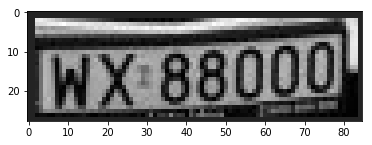

In [400]:
img = cv.imread(str(DATA_DIR / '5.jpg'))

rotated_img = rotate_image(img, 0)
plates = detect_plates(rotated_img, greyscale=True)

img = plates[0]
plt.imshow(img)

### Canny experimentail

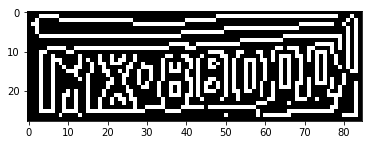

In [401]:
from skimage import feature, measure

edges = feature.canny(img/255.)
plt.imshow(edges)

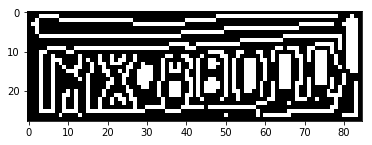

In [402]:
from skimage.morphology import square

filled = ndi.binary_fill_holes(edges, structure=None)
plt.imshow(filled)

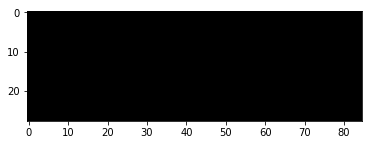

In [403]:
label_objects, nb_labels = ndi.label(filled)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 200
mask_sizes[0] = 0
cleaned = mask_sizes[label_objects]

plt.imshow(cleaned)

### Character segmentation

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


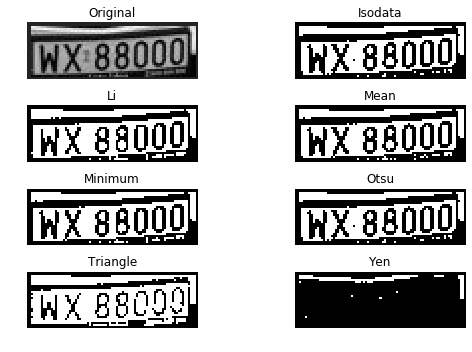

In [404]:
_ = filters.try_all_threshold(img)

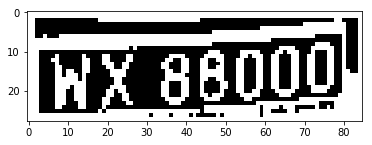

In [405]:
bin_img = img < filters.threshold_minimum(img)
plt.imshow(bin_img)

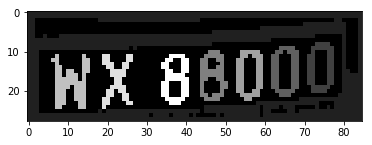

In [406]:
labeled_characters, _ = ndi.label(bin_img)
plt.imshow(labeled_characters)

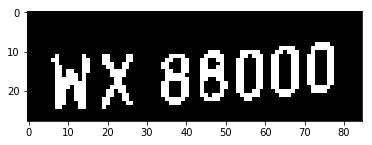

In [407]:
labeled_characters = (labeled_characters > 1).astype(np.int8)
plt.imshow(labeled_characters)

In [408]:
def get_position_and_shapes_from_contour(contour):
    xs, ys = zip(*[i for i in contour])
    
    x = int(min(xs))
    y = int(min(ys))
    w = int(max(xs) - x + 2)
    h = int(max(ys) - y + 2)

    return x, y, w, h

In [409]:
def right_edge_median(img):
    return np.median(img[:,0])

In [410]:
def reject_outliers_mask(data, m=2.):
    data = np.array(data)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return s < m

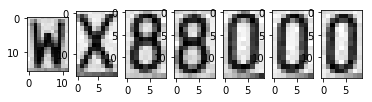

In [411]:
MIN_HEIGHT = 10
RIGHT_EDGE_THRESH = 50

cont_positions = []
for i, contours in enumerate(measure.find_contours(labeled_characters, .1)):
    x, y, w, h = get_position_and_shapes_from_contour(contours)

    if w > MIN_HEIGHT:
        cont_positions.append((y, x, h, w))
        
blobs = (cut_detection(img, cont) 
                  for cont in sorted(cont_positions))

blobs = list(filter(lambda img: right_edge_median(img) > RIGHT_EDGE_THRESH, blobs))

heights = [img.shape[0] for img in blobs]
outliers_mask = reject_outliers_mask(heights, m=3.)

blobs = np.array(blobs)[outliers_mask]

fig, axs = plt.subplots(1, len(blobs))
for i, letter in enumerate(blobs):
    axs[i].imshow(letter)

### Alternative segmentation

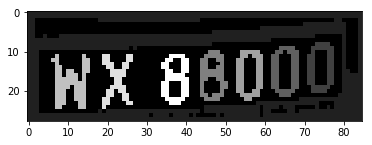

In [412]:
label_img, _ = ndi.label(bin_img)
props = measure.regionprops(label_img)

plt.imshow(label_img)

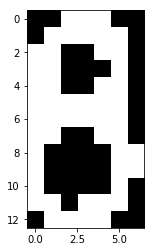

In [413]:
plt.imshow(props[3].image)

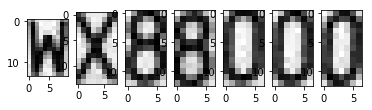

In [414]:
props = np.array([p for p in props if p.area > 15])

heights = [p.bbox[2] - p.bbox[0] for p in props]
outliers_mask = reject_outliers_mask(heights, m=3.)
props = props[outliers_mask]

sorted_props = sorted(props, key=lambda p: p.bbox[1])

fig, axs = plt.subplots(1, len(props))
for i, prop in enumerate(sorted_props):
    min_row, min_col, max_row, max_col = prop.bbox
    cut_char = img[min_row:max_row, min_col:max_col]
    axs[i].imshow(cut_char)